In [64]:
import numpy as np
import matplotlib.pyplot as plt
from epymorph.forecasting.likelihood import Poisson,Gaussian,NegativeBinomial
from epymorph.attribute import NamePattern
from epymorph.kit import *

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
    UnknownParam
)

from epymorph.simulation import Context
from epymorph.adrio import acs5, us_tiger
from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck

In [65]:
from typing_extensions import override
from epymorph.initializer import _POPULATION_ATTR
from epymorph.initializer import *

class RandomLocationsAndRandomSeed(SeededInfection):
    """
    Seed an random number of infected in a number of randomly selected locations.

    Requires "population" as a data attribute.

    Parameters
    ----------
    num_locations :
        The number of locations to choose.
    seed_max :
        The maximum number of individuals to infect.
    initial_compartment :
        Which compartment (by index or name) is "not infected", where most individuals
        start out.
    infection_compartment :
        Which compartment (by index or name) will be seeded as the initial infection.
    """

    requirements = (_POPULATION_ATTR,)

    num_locations: int
    """The number of locations to choose (randomly)."""
    seed_max: int
    """The maximum number of individuals to infect, drawn uniformly on [0,seed_max]."""

    def __init__(
        self,
        num_locations: int,
        seed_max: int,
        initial_compartment: int | str = SeededInfection.DEFAULT_INITIAL,
        infection_compartment: int | str = SeededInfection.DEFAULT_INFECTION,
    ):
        super().__init__(initial_compartment, infection_compartment)
        self.num_locations = num_locations
        self.seed_max = seed_max

    @override
    def evaluate(self) -> SimArray:
        """
        Evaluate the initializer in the current context.

        Returns
        -------
        :
            The initial populations for each node and IPM compartment.
        """
        N = self.scope.nodes
        if not 0 < self.num_locations <= N:
            err = (
                "Initializer argument 'num_locations' must be "
                f"a value from 1 up to the number of locations ({N})."
            )
            raise InitError(err)

        indices = np.arange(N, dtype=np.intp)
        selection = self.rng.choice(indices, self.num_locations)
        seed_size = self.rng.integers(low = 0, high = self.seed_max, endpoint=True)

        sub = IndexedLocations(
            selection=selection,
            seed_size=seed_size,
            initial_compartment=self.initial_compartment,
            infection_compartment=self.infection_compartment,
        )
        return self.defer(sub)

In [66]:
scope = CountyScope.in_states(['AZ'],year=2015)
sim_movement_model = mm.Centroids()
sim_ipm = ipm.SIRH()
sim_time_frame = TimeFrame.of("2015-01-01", 365)
my_rng = np.random.default_rng(0)

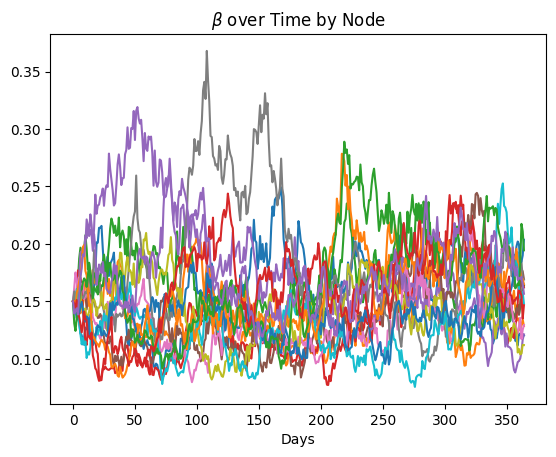

In [67]:
'''Generate a random time dependent beta'''
log_beta_damping = 1/35 * np.ones(scope.nodes)
log_beta_mean = np.log(0.15) * np.ones(scope.nodes)
log_beta_standard_deviation = 0.25 * np.ones(scope.nodes)
initial_log_beta = np.log(0.15) * np.ones(scope.nodes)

delta_t = 1. 

A = np.exp(-log_beta_damping * delta_t)
M = log_beta_mean * (np.exp(-log_beta_damping * delta_t) - 1)
C = log_beta_standard_deviation * np.sqrt(1-np.exp(-2*log_beta_damping * delta_t))

log_beta = np.zeros((scope.nodes,sim_time_frame.duration_days,))
log_beta[:,0] = initial_log_beta

for day in range(1,sim_time_frame.duration_days): 
    log_beta[:,day] = A * log_beta[:,day-1] - M + C * my_rng.normal(size = (scope.nodes,))

beta = np.exp(log_beta)

plt.title('$\\beta$ over Time by Node')
plt.xlabel('Days')
for node in range(scope.nodes): 
    plt.plot(beta[node,:],label = f"Node: {node}")
plt.show()


In [68]:
rume = SingleStrataRUME.build(
    ipm=sim_ipm,
    mm=sim_movement_model,
    # Describe the geographic scope of our simulation:
    scope= scope,
    # Create a SingleLocation initializer
    init=init.RandomLocations(scope.nodes,
                                seed_size=1000),
    # Set the time-frame to simulate
    time_frame=sim_time_frame,
    # Provide model parameter values
    params={
        "beta": beta.T,
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "hospitalization_prob":0.05,
        "hospitalization_duration":5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population(),
        "label":us_tiger.Name()
    },
)


In [69]:

# Construct a simulator for the RUME
sim = BasicSimulator(rume)

# Run inside a sim_messaging context to display a nice progress bar
with sim_messaging():
    # Run and save the simulation Output object for later
    out = sim.run(
        # Use a seeded RNG (for the sake of keeping this notebook's results consistent)
        # This parameter is optional; by default a new RNG is constructed for each run
        # using numpy's default_rng
        rng_factory=lambda : my_rng
    )

Loading gpm:all::mm::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.859s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-12-31 (365 days)
• 15 geo nodes
  |####################| 100%                     
Runtime: 1.103s


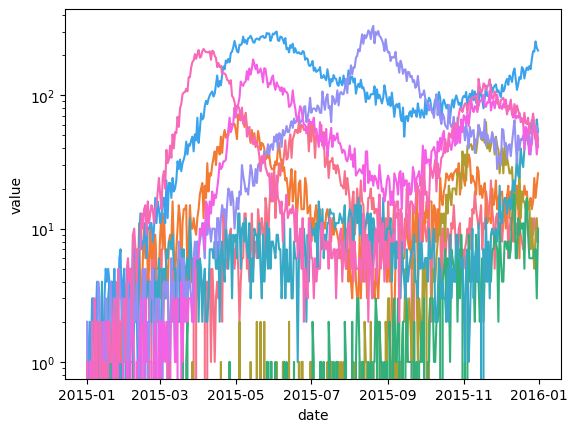

In [70]:

# Plot the compartment values in States throughout the simulation.
from epymorph.adrio import csv
from epymorph.tools.data import munge
import seaborn as sns


cases_df = munge(
    out,
    quantity=rume.ipm.select.events("I->H"),
    time=rume.time_frame.select.all().group("day").agg(),
    geo=rume.scope.select.all(),
)

cases_df.columns = ['date','geoid','value']

ax = sns.lineplot(data=cases_df,x='date',y='value',hue = 'geoid',legend=False)
ax.set(yscale='log') 
plt.show()

cases_df.to_csv('./synthetic_data.csv',index=False)

csvadrio = csv.CSVFileAxN(
    file_path='./synthetic_data.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)


## Implementation Details of the Stochastic EnKF
The following will describe the implementation details of the stochastic EnKF update implemented by Avery on 1/14/26. 

### Definitions: 

The observation $y_t \in \mathbb{R}^{N_e \times N}$, where $N_e$ is the number of ensemble members and 
$N$ is the number of nodes in the epymorph model. This is denoted as `observation_array["value"][0, :]` 
in the code. 

Observation variance $\sigma^2$, assumed to be the same for each node. This is `self.observations.likelihood.variance`
in the code. 

The observation noise matrix $\sigma^2 \cdot I_{N \times N}$. This is denoted as `R_obs` in the code. 

The ensemble $X_{prior} \in \mathbb{R}^{N_e \times (N\cdot C + N\cdot P)}$ where $C$ is the number of compartments in the 
epymorph model and $P$ is the number of estimated params. The state ensemble is extended by concatenating the 
estimated parameters at the end. This is denoted as `ensemble` in the code. 

The predicted observations $Y_{prior} \in \mathbb{R}^N$ associated with the ensemble. These are denoted `pred_observations`.  

The prior ensemble mean $\bar{X}_{prior} \in \mathbb{R}^{(N\cdot C + N\cdot P)}$ denoted `mean` and ensemble perturbation matrix 
$A = \frac{(X_{prior} - \bar{X}_{prior})}{\sqrt{N_e - 1}}$ denoted `state_perturbation_matrix`. 

The prior observation mean $\bar{Y}_{prior} \in \mathbb{R}^{N}$ denoted `obs_mean` and observation perturbation matrix 
$B = \frac{(Y_{prior} - \bar{Y}_{prior})}{\sqrt{N_e - 1}}$ denoted `obs_perturbation_matrix`. 

The matrix $S = B^T B + R_{obs}$ where $S \in R^{N \times N}$. This matrix is inverted in the kalman gain expression, denoted `S` in the code. 

The matrix $C = A^T B$ which is the cross covariance of the state and observation, denoted `cross_cov` in the code. 

### The Kalman Update

In the update step we do 

$X_{post}^{i} = X_{prior}^{i} + C S^{-1}(y_t + \epsilon^{i} - Y_{prior}^{i})$ where $\epsilon^{i} \sim \mathcal{N}(0,R_{obs})$. In 
the code $(y_t + \epsilon^{i} - Y_{prior}^{i})$ is collected in a vector `alpha`. 

The updated ensemble is then saved to arrays holding compartment values and parameter values. 

In [71]:
from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.forecasting.pipeline import EnsembleKalmanFilterSimulator, ParticleFilterSimulator


num_realizations = 25

enkf_rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=sim_ipm,
    # Load the Pei MM
    mm=sim_movement_model,
    # Describe the geographic scope of our simulation:
    scope=scope,
    # Create a SingleLocation initializer
    init=RandomLocationsAndRandomSeed(scope.nodes,1000),
    # Set the time-frame to simulate
    time_frame=sim_time_frame,
    # Provide model parameter values
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "hospitalization_prob":0.05,
        "hospitalization_duration":5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

my_observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        geo=enkf_rume.scope.select.all(),
        time=enkf_rume.time_frame.select.all().group("day").agg(),
        quantity=enkf_rume.ipm.select.events("I->H"),
    ),
    likelihood=Gaussian(50.0)
)

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    )
}

enkf_simulator = EnsembleKalmanFilterSimulator(
        config=FromRUME(enkf_rume,num_realizations,unknown_params = my_unknown_params),
        observations=my_observations,
        save_trajectories=True,
    )

pf_simulator = ParticleFilterSimulator(
        config=FromRUME(enkf_rume,num_realizations,unknown_params = my_unknown_params),
        observations=my_observations,
        save_trajectories=True,
    )


In [72]:
enkf_output = enkf_simulator.run(rng=my_rng)
pf_output = pf_simulator.run(rng=my_rng)

Observation: 364, Label: 2015-12-31, Time Frame: 2015-12-31 (1D)
Runtime with 25 members and 15 Nodes is 90.5 seconds.
Observation: 364, Label: 2015-12-31, Time Frame: 2015-12-31 (1D)
Runtime with 25 particles and 15 Nodes is 91.63142329200491 seconds.


In [73]:

context = Context.of(
    scope=enkf_rume.scope,
    time_frame=enkf_rume.time_frame,
    rng=my_rng,
)
real_data_result = (
    my_observations.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]
real_data_dates = real_data_result["date"][:, 0]

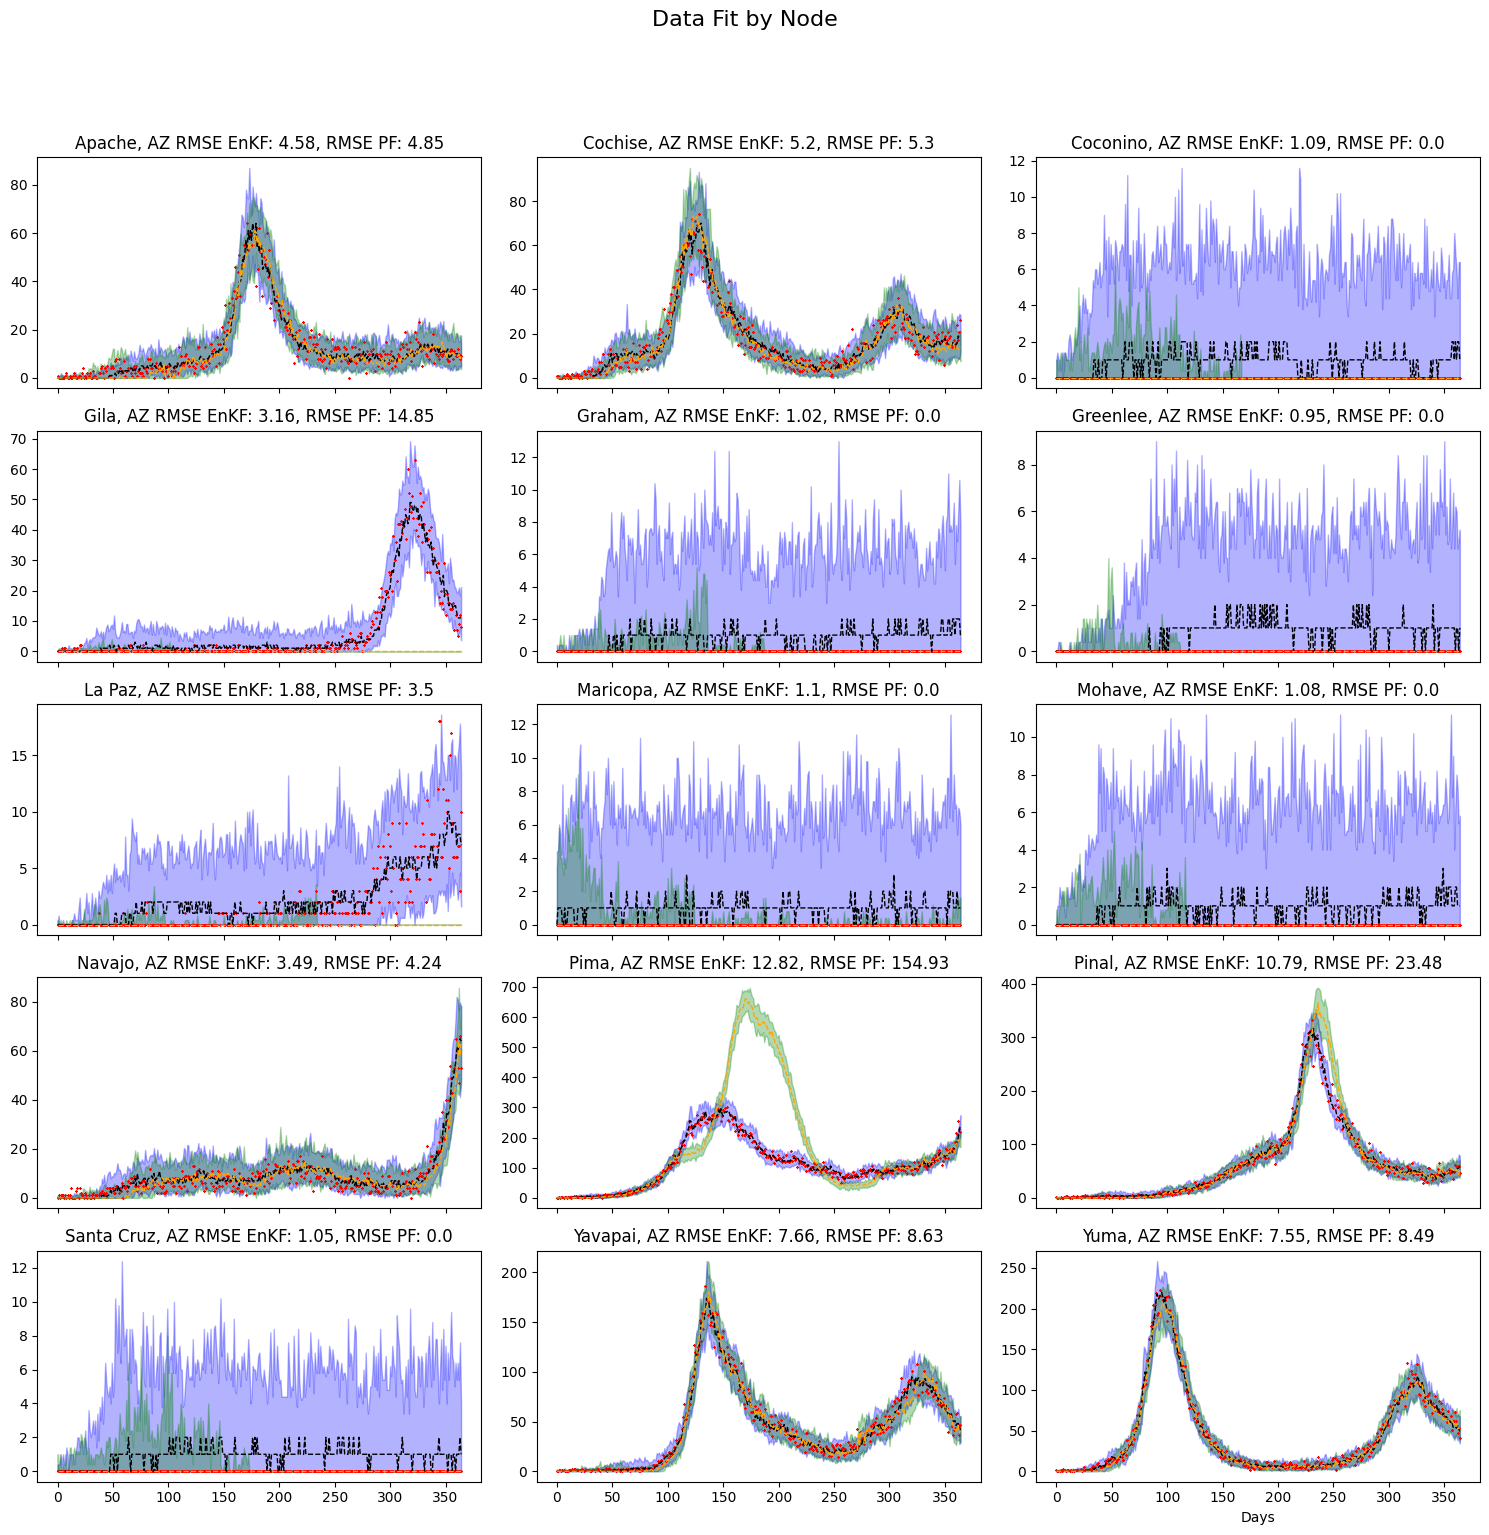

In [75]:
import math

t_range = np.arange(enkf_rume.time_frame.duration_days)

posterior_obs_enkf = enkf_output.events.reshape(
    (num_realizations, enkf_rume.time_frame.duration_days, 2, enkf_rume.scope.nodes, 5)
)

posterior_obs_enkf = posterior_obs_enkf.sum(axis=2)

posterior_obs_pf = pf_output.events.reshape(
    (num_realizations, enkf_rume.time_frame.duration_days, 2, enkf_rume.scope.nodes, 5)
)
posterior_obs_pf = posterior_obs_pf.sum(axis=2)

num_nodes = enkf_rume.scope.nodes
labels = enkf_rume.scope.labels


cols = 3 
rows = math.ceil(num_nodes / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(cols * 5, rows * 3),
    sharex=True,
    sharey=False
)

axes = axes.flatten()

plt.suptitle("Data Fit by Node", fontsize=16, y=1.02)


for node in range(num_nodes):
    ax = axes[node]
    
    upper_enkf = np.percentile(posterior_obs_enkf[:, :, node, 1], 97.5, axis=0)
    lower_enkf = np.percentile(posterior_obs_enkf[:, :, node, 1], 2.5, axis=0)
    data_median_enkf = np.median(posterior_obs_enkf[:, :, node, 1], axis=0)

    upper_pf = np.percentile(posterior_obs_pf[:, :, node, 1], 97.5, axis=0)
    lower_pf = np.percentile(posterior_obs_pf[:, :, node, 1], 2.5, axis=0)
    data_median_pf = np.median(posterior_obs_pf[:, :, node, 1], axis=0)
    
    with np.errstate(under="warn"):
        rmse_enkf = np.round(np.sqrt(np.mean((data_median_enkf - real_data[:, node])**2)),2)
        rmse_pf = np.round(np.sqrt(np.mean((data_median_pf - real_data[:, node])**2)),2)

    ax.set_title(f"{labels[node]} RMSE EnKF: {rmse_enkf}, RMSE PF: {rmse_pf}", fontsize=12)
    ax.plot(t_range, data_median_enkf, '--', color='black', linewidth=1, label="mean of EnKF")
    ax.plot(t_range, data_median_pf, '--', color='orange', linewidth=1, label="mean of PF")
    ax.fill_between(t_range, lower_enkf, upper_enkf, color='blue', alpha=0.3,label = '95% CI EnKF')
    ax.fill_between(t_range, lower_pf, upper_pf, color='green', alpha=0.3,label = '95% CI PF')
    ax.scatter(t_range, real_data[:, node], color='red', s=1, marker='x', label="data")


for i in range(num_nodes, len(axes)):
    axes[i].set_visible(False)


axes[-1].set_xlabel("Days")
fig.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()


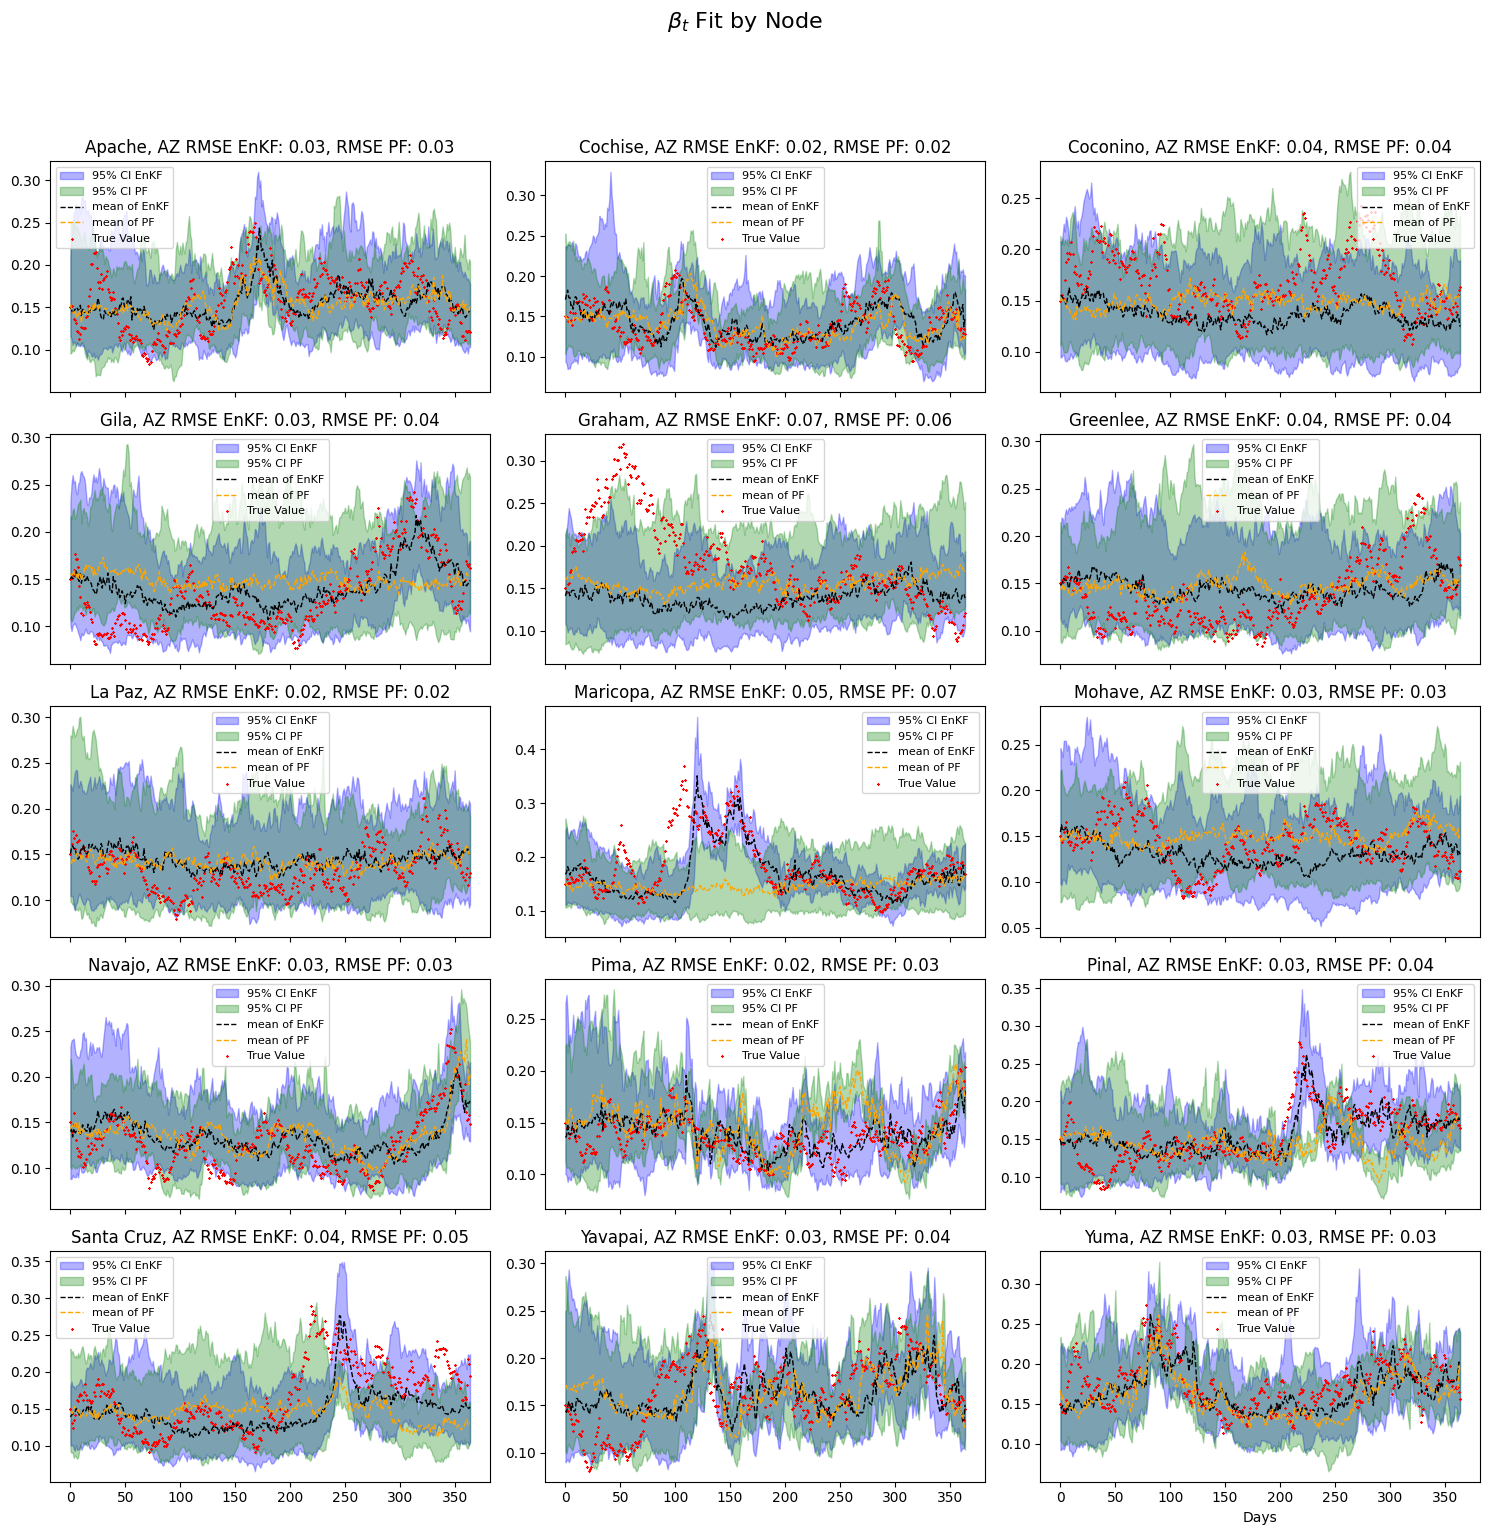

In [ ]:
num_nodes = enkf_rume.scope.nodes
labels = enkf_rume.scope.labels

log_beta_enkf = enkf_output.estimated_params[NamePattern.of("log_beta")]
log_beta_pf = pf_output.estimated_params[NamePattern.of("log_beta")]

cols = 3
rows = math.ceil(num_nodes / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(cols * 5, rows * 3),
    sharex=True,
    sharey=False
)

axes = axes.flatten()

plt.suptitle(r'$\beta_t$ Fit by Node', fontsize=16, y=1.02)

for node in range(num_nodes):
    ax = axes[node]

    upper_enkf = np.exp(np.percentile(log_beta_enkf[:, :, node], 97.5, axis=0))
    lower_enkf = np.exp(np.percentile(log_beta_enkf[:, :, node], 2.5, axis=0))
    beta_median_enkf = np.exp(np.median(log_beta_enkf[:, :, node], axis=0))

    upper_pf = np.exp(np.percentile(log_beta_pf[:, :, node], 97.5, axis=0))
    lower_pf = np.exp(np.percentile(log_beta_pf[:, :, node], 2.5, axis=0))
    beta_median_pf = np.exp(np.median(log_beta_pf[:, :, node], axis=0))

    with np.errstate(under="warn"):
        rmse_enkf = np.round(np.sqrt(np.mean((beta_median_enkf - beta[node,:])**2)),2)
        rmse_pf = np.round(np.sqrt(np.mean((beta_median_pf - beta[node,:])**2)),2)

    ax.set_title(f"{labels[node]} RMSE EnKF: {rmse_enkf}, RMSE PF: {rmse_pf}", fontsize=12)

    ax.fill_between(t_range, lower_enkf, upper_enkf, alpha=0.3, color="blue",label = '95% CI EnKF')
    ax.fill_between(t_range, lower_pf, upper_pf, alpha=0.3, color="green", label = '95% CI PF')

    ax.plot(t_range, beta_median_enkf, '--', color="black", linewidth=1, label="mean of EnKF")
    ax.plot(t_range, beta_median_pf, '--', color="orange", linewidth=1, label="mean of PF")

    ax.scatter(
        t_range,
        beta[node, :],
        color="red",
        s=1,
        marker='x',
        label="True Value"
    )

    ax.legend(fontsize=8)

for i in range(num_nodes, len(axes)):
    axes[i].set_visible(False)

axes[-1].set_xlabel("Days")

fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


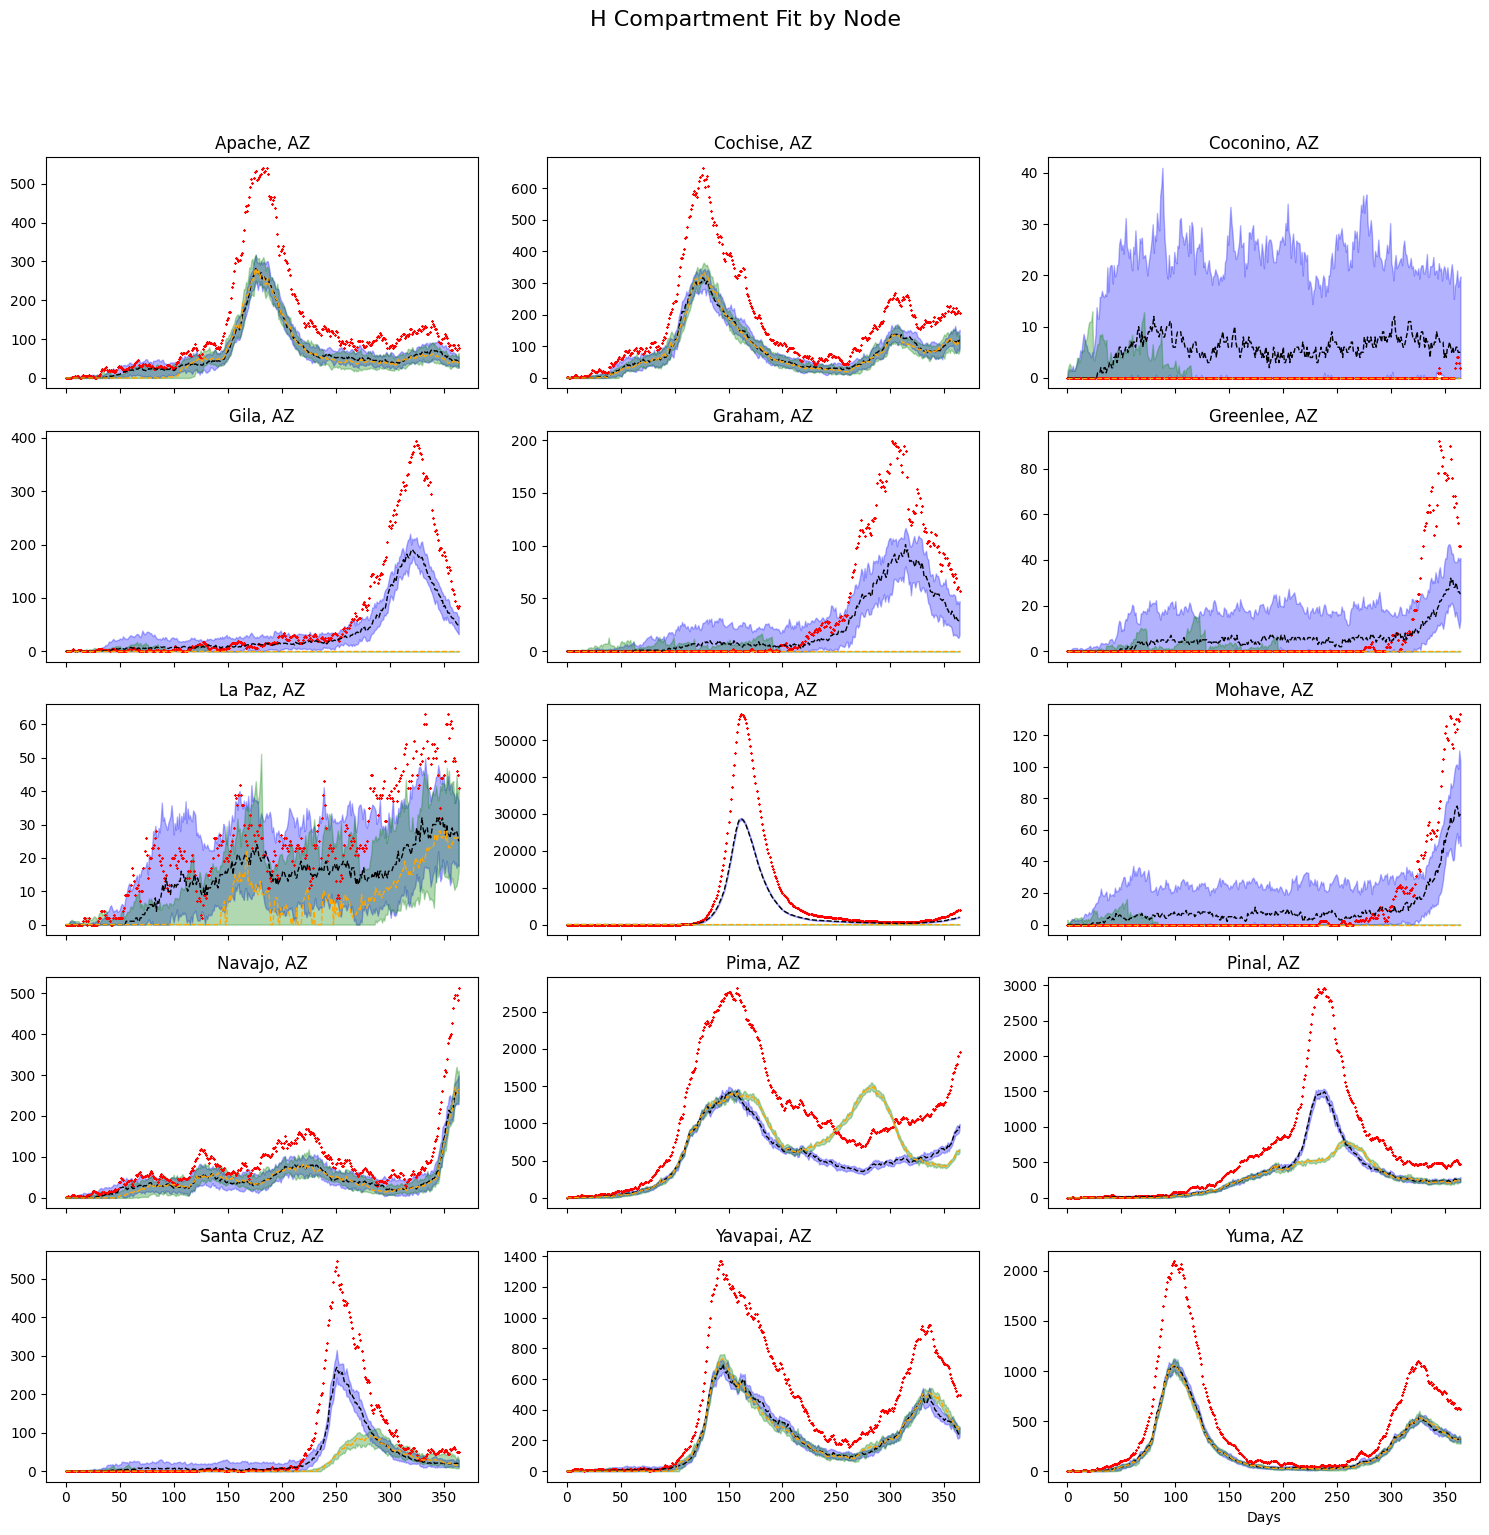

In [ ]:
import math
import matplotlib.pyplot as plt

t_range = np.arange(enkf_rume.time_frame.duration_days)

posterior_obs_enkf = enkf_output.compartments.reshape(
    (num_realizations, enkf_rume.time_frame.duration_days, 2, enkf_rume.scope.nodes, 4)
)
posterior_obs_enkf = posterior_obs_enkf.sum(axis=2)

posterior_obs_pf = pf_output.compartments.reshape(
    (num_realizations, enkf_rume.time_frame.duration_days, 2, enkf_rume.scope.nodes, 4)
)
posterior_obs_pf = posterior_obs_pf.sum(axis=2)

real_H = out.compartments.reshape(enkf_rume.time_frame.duration_days, 2, enkf_rume.scope.nodes,4)
real_H = real_H.sum(axis = 1)


num_nodes = enkf_rume.scope.nodes
labels = enkf_rume.scope.labels


cols = 3 
rows = math.ceil(num_nodes / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(cols * 5, rows * 3),
    sharex=True,
    sharey=False
)

axes = axes.flatten()

plt.suptitle("H Compartment Fit by Node", fontsize=16, y=1.02)

for node in range(num_nodes):
    ax = axes[node]
    
    upper_enkf = np.percentile(posterior_obs_enkf[:, :, node, -1], 97.5, axis=0)
    lower_enkf = np.percentile(posterior_obs_enkf[:, :, node, -1], 2.5, axis=0)
    data_median_enkf = np.median(posterior_obs_enkf[:, :, node, -1], axis=0)

    upper_pf = np.percentile(posterior_obs_pf[:, :, node, -1], 97.5, axis=0)
    lower_pf = np.percentile(posterior_obs_pf[:, :, node, -1], 2.5, axis=0)
    data_median_pf = np.median(posterior_obs_pf[:, :, node, -1], axis=0)

    ax.set_title(f"{labels[node]}", fontsize=12)
    ax.plot(t_range, data_median_enkf, '--', color='black', linewidth=1, label="mean of EnKF")
    ax.plot(t_range, data_median_pf, '--', color='orange', linewidth=1, label="mean of PF")
    ax.fill_between(t_range, lower_enkf, upper_enkf, color='blue', alpha=0.3,label = '95% CI EnKF')
    ax.fill_between(t_range, lower_pf, upper_pf, color='green', alpha=0.3,label = '95% CI PF')
    ax.scatter(t_range, real_H[:, node,-1], color='red', s=1, marker='x', label="data")


for i in range(num_nodes, len(axes)):
    axes[i].set_visible(False)


axes[-1].set_xlabel("Days")
fig.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()
